In [1]:
import torch
import math
import numpy as np
import xalglib
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

from time import clock_gettime, CLOCK_MONOTONIC
from CubicEquationSolver import solve as solve_cubic

# Problem

## sklearn: LogisticRegression

In [2]:
X, y = load_breast_cancer(True)
X = (X - X.mean(axis=0)) / X.std(axis=0) + np.random.randn(*X.shape)
X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

In [3]:
log_reg = LogisticRegression(penalty='none', fit_intercept=False, solver='newton-cg', tol=1e-7)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=1e-07, verbose=0,
                   warm_start=False)

In [4]:
x_opt = log_reg.coef_[0]

In [5]:
x_opt

array([-0.38768368, -0.49994833, -0.59541948, -0.39849101, -0.46836326,
        0.05606896, -0.52595313, -0.64947702, -0.0090894 , -0.05547195,
       -0.5520733 ,  0.23525235, -0.12438167, -0.32129765,  0.11368458,
        0.07847555,  0.2410645 , -0.36537693, -0.08385033,  0.493171  ,
       -0.54010285, -0.96178676, -0.97699409, -0.58642306, -0.42297448,
       -0.22330365, -0.26123462, -0.28766289, -0.43890332,  0.10174956,
        0.95363823])

In [6]:
log_reg.score(X, y)

0.9384885764499121

In [7]:
log_loss(y, log_reg.predict_proba(X))

0.13935816325588316

## PyTorch: optimization problem

In [8]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

x_opt = torch.tensor(x_opt, dtype=torch.float32)
N = x_opt.shape[0]

x_0 = torch.randn(N)

In [9]:
def f(x):
    return torch.nn.functional.binary_cross_entropy_with_logits(X @ x, y)

In [10]:
f(x_opt).item()

0.13935816287994385

In [11]:
f(x_0).item()

3.643639326095581

In [12]:
def check_optimality(f, x, step=1e-4, eps=1e-7):
    n = x.shape[0]
    fx = f(x)
    for i in range(n):
        for s in [-1, 1]:
            y = x.clone()
            y[i] += s * step
            fy = f(y)
            if fy < fx - eps:
                return False
    return True

In [13]:
check_optimality(f, x_0)

False

In [14]:
check_optimality(f, x_opt)

True

# Helper functions

In [15]:
def d_p(x, p):
    '''
    Prox-function
    '''
    return 1 / p * torch.norm(x)**p


def gradient(f, x, create_graph=False, retain_graph=None):
    '''
    Gradient of scalar function 'f' w.r.t. 1-d vector 'x'
    '''
    return torch.autograd.grad(
        outputs=[f],
        inputs=[x],
        create_graph=create_graph, 
        retain_graph=retain_graph)[0]


def hessian(f, x, create_graph=False):
    '''
    Hessian of scalar function 'f' w.r.t. 1-d vector 'x'
    '''
    n = x.shape[0]
    h = torch.empty(n, n)
    g = gradient(f, x, True)
    for i in range(n):
        h[i] = gradient(g[i], x, create_graph, True)
    return h


def D3(f, x, create_graph=False):
    n = x.shape[0]
    d3 = torch.empty(n, n, n)
    g = gradient(f, x, True)
    for i in range(n):
        d3[i] = hessian(g[i], x, create_graph)
    return d3


def hessian_vector_product(f, x, v, retain_graph=False):
    '''
    Hessian-vector product: D^2(f) @ v
    '''
    grad_f = gradient(f, x, True)
    return gradient(grad_f @ v, x, retain_graph=retain_graph)

In [16]:
def test():
    x = torch.tensor([1.5, 2.5], requires_grad=True)
    e = torch.tensor([1., 1.])
    f = x.pow(2).prod()
    print('F =', f, '\n')

    g = gradient(f, x, retain_graph=True)
    print('g =', g, '\n')

    h = hessian(f, x)
    print('h =', h, '\n')

    he = hessian_vector_product(f, x, e, retain_graph=True)
    print('h @ e =', he, '\n')
    
    d3 = D3(f, x)
    print('d3 =', d3, '\n')

test()

F = tensor(14.0625, grad_fn=<ProdBackward0>) 

g = tensor([18.7500, 11.2500]) 

h = tensor([[12.5000, 15.0000],
        [15.0000,  4.5000]]) 

h @ e = tensor([27.5000, 19.5000]) 

d3 = tensor([[[ 2.8610e-06,  1.0000e+01],
         [ 1.0000e+01,  6.0000e+00]],

        [[ 1.0000e+01,  6.0000e+00],
         [ 6.0000e+00, -1.4305e-06]]]) 



# Auxilary problem

## Original problem

In [137]:
def auxilary_problem_objective(h, A, c, gamma):
    value = .5 * A @ h @ h + c @ h + gamma * torch.norm(h)**4 / 4
    return value


def solve_auxilary_problem_autograd_vanilla_gd(A, c, gamma, h_0, learning_rate=0.001, n_iter=1000):
    h = h_0.clone().detach().requires_grad_()
    for i in range(n_iter):
        value = auxilary_problem_objective(h, A, c, gamma)
        grad = gradient(value, h)
        with torch.no_grad():
            h -= learning_rate * grad
    return h


def solve_auxilary_problem_analytic_vanilla_gd(A, c, gamma, h_0, learning_rate=0.001, n_iter=1000):
    h = h_0.clone().detach()
    for i in range(n_iter): 
        grad = A @ h + c + gamma * torch.norm(h)**2 * h
        with torch.no_grad():
            h -= learning_rate * grad
    return h


def solve_auxilary_problem_analytic_gd_grad_norm(A, c, gamma, h_0, learning_rate=0.001, min_grad_norm=1e-3):
    h = h_0.clone().detach()
    while True:
        grad = A @ h + c + gamma * torch.norm(h)**2 * h
        grad_norm = torch.norm(grad)
        if grad_norm < min_grad_norm:
            break
        with torch.no_grad():
            h -= learning_rate * grad
    return h


def solve_auxilary_problem_exact_gd_np(A, c, gamma, h_0, min_step_size=1e-5):
    h = h_0.clone().detach()
    
    def opt_learning_rate():
        gh = g @ h
        hh = h_norm ** 2
        gg = g_norm ** 2
        a3 =      gamma * gg**2
        a2 = -3 * gamma * gg * gh
        a1 =  gamma * hh * gg + 2 * gamma * gh**2 + A @ g @ g
        a0 = -gamma * hh * gh - Ah @ g - c @ g
        root = [r.real for r in np.roots([a3, a2, a1, a0]) if r.imag == 0][0]
        return root
    
    while True:
        h_norm = torch.norm(h)
        Ah = A @ h
        g = Ah + c + gamma * h_norm**2 * h
        g_norm = torch.norm(g)
        learning_rate = opt_learning_rate()
        if g_norm * learning_rate < min_step_size:
            break
        with torch.no_grad():
            h -= learning_rate * g
    return h


def solve_auxilary_problem_exact_gd(A, c, gamma, h_0, min_step_size=1e-5):
    h = h_0.clone().detach()
    
    def opt_learning_rate():
        gh = g @ h
        gg = g_norm ** 2
        gamma_gg = gamma * gg
        gamma_hh = gamma * hh
        a3 =      gamma_gg * gg
        a2 = -3 * gamma_gg * gh
        a1 =  gamma_hh * gg + 2 * gamma * gh**2 + A @ g @ g
        a0 = -gamma_hh * gh - Ah @ g - c @ g
        root = [r.real for r in solve_cubic(a3.item(), a2.item(), a1.item(), a0.item()) if r.imag == 0][0]
        return root
    
    while True:
        h_norm = torch.norm(h)
        Ah = A @ h
        hh = h_norm ** 2
        g = Ah + c + gamma * hh * h
        g_norm = torch.norm(g)
        learning_rate = opt_learning_rate()
        if g_norm * learning_rate < min_step_size:
            break
        with torch.no_grad():
            h -= learning_rate * g
    return h


def solve_auxilary_problem_exact_newton(A, c, gamma, h_0, eps=1e-7):
    h = h_0.clone().detach()
    
    def opt_learning_rate():
        sh = s @ h
        ss = s_norm ** 2
        gamma_ss = gamma * ss
        gamma_hh = gamma * hh
        a3 =      gamma_ss * ss
        a2 = -3 * gamma_ss * sh
        a1 =  gamma_hh * ss + 2 * gamma * sh**2 + A @ s @ s
        a0 = -gamma_hh * sh - Ah @ s - c @ s
        root = [r.real for r in solve_cubic(a3.item(), a2.item(), a1.item(), a0.item()) if r.imag == 0][0]
        return root
    
    def outer(a, b):
        return torch.unsqueeze(a, 1) @ torch.unsqueeze(b, 0)
    
    I = torch.eye(len(c))
    while True:
        h_norm = torch.norm(h)
        Ah = A @ h
        hh = h_norm ** 2
        g = Ah + c + gamma * hh * h
        H = A + gamma * (2 * outer(h, h) + hh**2 * I)
        s = torch.inverse(H) @ g
        lmb_square = s @ g
        s_norm = torch.norm(s)
        learning_rate = opt_learning_rate()
        if lmb_square < eps:
            break
        with torch.no_grad():
            h -= learning_rate * s
    return h

In [139]:
def test(solve, N):
    times = []
    for _ in range(N):
        A = torch.diag(torch.abs(torch.randn(4)))
        k = 1
        e_k = torch.zeros(4)
        e_k[k] = 1
        c = (10 + 10 * torch.abs(torch.randn(1))) * e_k
        gamma = 100 * torch.abs(torch.randn(1))
        h_0 = torch.ones_like(c)
        
        start = clock_gettime(CLOCK_MONOTONIC)
        h = solve(A, c, gamma, h_0)
        end = clock_gettime(CLOCK_MONOTONIC)
        times.append(end - start)
    
    print('A =', A, '\n')
    print('c =', c, '\n')
    print('gamma =', gamma, '\n')
    
    print('Time:', np.mean(times), '\n')
    print('h =', h)

    def f(h):
        return c @ h + .5 * h.T @ A @ h + gamma * torch.norm(h)**4 / 4

    xx = np.linspace(-2, 2, 1000)
    yy = [f(x * e_k) for x in xx]
    plt.plot(xx, yy)
    y1, y2 = min(yy) - 10, min(yy) + 100
    plt.ylim(y1, y2)
    plt.plot([h[k], h[k]], [y1, y2])

A = tensor([[0.7188, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.4055, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6229, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.5618]]) 

c = tensor([ 0.0000, 11.7061,  0.0000,  0.0000]) 

gamma = tensor([110.1773]) 

Time: 0.2673102970002219 

h = tensor([ 1.1067e-11, -4.6465e-01,  1.2211e-11,  4.6593e-12],
       requires_grad=True)


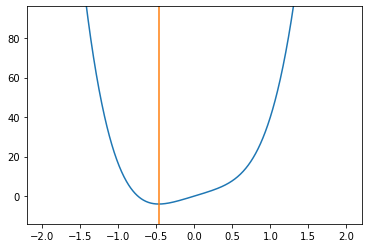

In [121]:
test(lambda A, c, gamma, h_0: solve_auxilary_problem_autograd_vanilla_gd(A, c, gamma, h_0), 1)

A = tensor([[1.4838, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.4428, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6582, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.3506]]) 

c = tensor([ 0.0000, 25.9074,  0.0000,  0.0000]) 

gamma = tensor([53.7215]) 

Time: 0.038593867169111035 

h = tensor([ 1.6109e-15, -7.7278e-01,  3.7837e-15,  1.8490e-15])


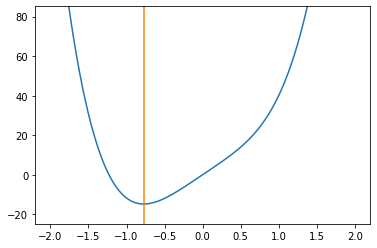

In [122]:
test(lambda A, c, gamma, h_0: solve_auxilary_problem_analytic_vanilla_gd(A, c, gamma, h_0), 100)

A = tensor([[0.8756, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1047, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.4985, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4581]]) 

c = tensor([ 0.0000, 19.1587,  0.0000,  0.0000]) 

gamma = tensor([7.3404]) 

Time: 0.02354154997796286 

h = tensor([ 3.7824e-05, -1.3734e+00,  2.3892e-05,  5.1454e-05])


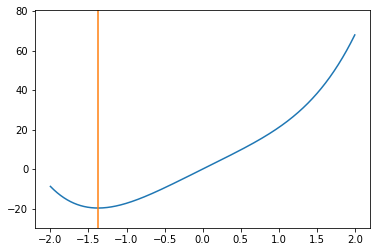

In [123]:
test(lambda A, c, gamma, h_0: solve_auxilary_problem_analytic_gd_grad_norm(A, c, gamma, h_0), 100)

A = tensor([[0.1618, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1263, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.6202, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0753]]) 

c = tensor([ 0.0000, 28.7374,  0.0000,  0.0000]) 

gamma = tensor([56.8591]) 

Time: 0.004305259448534343 

h = tensor([-6.3021e-06, -7.9562e-01, -3.1964e-06, -6.5526e-06])


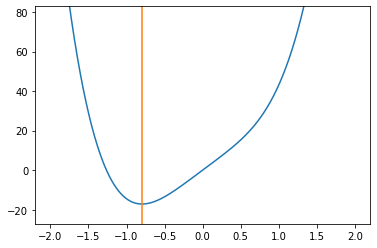

In [124]:
test(lambda A, c, gamma, h_0: solve_auxilary_problem_exact_gd_np(A, c, gamma, h_0), 1000)

A = tensor([[1.0187, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4451, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.2434, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1589]]) 

c = tensor([ 0.0000, 15.8616,  0.0000,  0.0000]) 

gamma = tensor([50.6918]) 

Time: 0.0026117690695100465 

h = tensor([-2.7098e-06, -6.7458e-01, -2.2792e-06, -5.1315e-06])


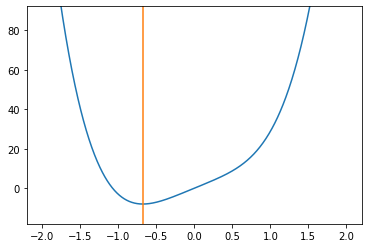

In [125]:
test(lambda A, c, gamma, h_0: solve_auxilary_problem_exact_gd(A, c, gamma, h_0), 1000)

A = tensor([[0.1687, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.7957, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0367, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8503]]) 

c = tensor([ 0.0000, 10.2092,  0.0000,  0.0000]) 

gamma = tensor([120.0387]) 

Time: 0.0017909875881159678 

h = tensor([-3.4920e-06, -4.2845e-01, -5.5505e-06,  4.6373e-08])


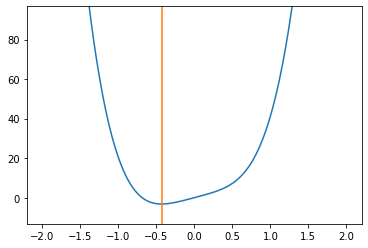

In [140]:
test(lambda A, c, gamma, h_0: solve_auxilary_problem_exact_newton(A, c, gamma, h_0), 1000)

In [247]:
def tridiag(d, e):
    '''
    Construct symmetric tridiagonal matrix from its main diagonal d and 
    above/below main diagonals equal to e
    '''
    return torch.diag(d) + torch.diag(e, -1) + torch.diag(e, 1)


def utu_decomposition(A):  # TODO
    '''
    Decomposition of symmetric matrix A to U @ T @ U.T, where
    U - symmetric ortogonal matrix, T - symmetric tridiagonla matrix
    '''
    a = A.tolist()
    N = len(a)
    a, tau, d, e = xalglib.smatrixtd(a, N, True)
    u = xalglib.smatrixtdunpackq(a, N, True, tau)
    U = torch.tensor(u)
    T = tridiag(torch.tensor(d), torch.tensor(e))
    return T, U


def auxilary_problem_objective(h, A, c, gamma):
    value = .5 * A @ h @ h + c @ h +gamma * torch.norm(h)**4 / 4
    return value


def solve_auxilary_problem_autograd_vanilla_gd(A, c, gamma, h_0, learning_rate=0.001, n_iter=1000):
    h = h_0.clone().detach().requires_grad_()
    for i in range(n_iter):
        value = auxilary_problem_objective(h, A, c, gamma)
        grad = gradient(value, h)
        with torch.no_grad():
            h -= learning_rate * grad
    return h


def solve_auxilary_problem_analytic_vanilla_gd(A, c, gamma, h_0, learning_rate=0.001, n_iter=1000):
    h = h_0.clone().detach()
    for i in range(n_iter): 
        grad = A @ h + c + gamma * torch.norm(h)**2 * h
        with torch.no_grad():
            h -= learning_rate * grad
    return h


def solve_auxilary_problem_analytic_gd_grad_norm(A, c, gamma, h_0, learning_rate=0.001, grad_norm=1e-5):
    h = h_0.clone().detach()
    
    for i in range(n_iter): 
        grad = A @ h + c + gamma * torch.norm(h)**2 * h
        with torch.no_grad():
            h -= learning_rate * grad
    return h


def solve_auxilary_problem_analytic_vanilla_gd(A, c, gamma, h_0, learning_rate=0.001, n_iter=1000):
    h = h_0.clone().detach()
    for i in range(n_iter): 
        grad = A @ h + c + gamma * torch.norm(h)**2 * h
        with torch.no_grad():
            h -= learning_rate * grad
    return h


# def auxilary_subproblem_objective(tau, T, c_tilda, gamma):
#     I = torch.eye(len(c_tilda))
#     value = tau**2 + .5 * c_tilda.T @ torch.inverse(2 * math.sqrt(gamma) * tau * I + T) @ c_tilda
#     return value


# def solve_auxilary_subproblem(T, c_tilda, gamma, learning_rate=0.1, n_iter=100):
#     tau = torch.tensor(1, dtype=torch.float32, requires_grad=True)
#     for i in range(n_iter):  # TODO
#         value = auxilary_subproblem_objective(tau, T, c_tilda, gamma)
#         grad = gradient(value, tau)
#         with torch.no_grad():
#             tau -= learning_rate * grad
#     return tau


# def solve_auxilary_problem(A, c, gamma, learning_rate=0.1, n_iter=100):
#     T, U = utu_decomposition(A)
#     c_tilda = U.T @ c
    
#     tau = solve_auxilary_subproblem(T, c_tilda, gamma, learning_rate, n_iter)
#     assert tau > 0
#     I = torch.eye(len(c_tilda))
#     h = -U @ torch.inverse(2 * math.sqrt(gamma) * tau * I + T) @ c_tilda
    
#     return h


def solve_auxilary_problem_exact_gd(A, c, gamma, h_0, ):
    h = h_0.clone().detach()
    for i in range(n_iter): 
        grad = A @ h + c + gamma * torch.norm(h)**2 * h
        with torch.no_grad():
            h -= learning_rate * grad
    return h

A = tensor([[0.8327, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0684, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8428, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0840]]) 

c = tensor([ 0.0000, 25.9040,  0.0000,  0.0000]) 

gamma = tensor([13.1424]) 

h = tensor([ 6.4381e-10, -1.2524e+00,  6.3726e-10,  1.3828e-09])


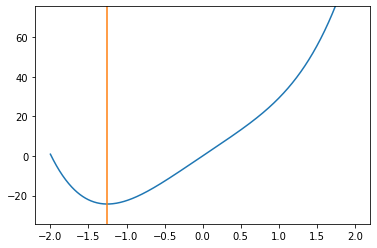

In [249]:
def test(solve):
    A = torch.diag(torch.abs(torch.randn(4)))
    k = 1
    e_k = torch.zeros(4)
    e_k[k] = 1
    c = (10 + 10 * torch.abs(torch.randn(1))) * e_k
    gamma = 100 * torch.abs(torch.randn(1))
    h_0 = torch.ones_like(c)

    print('A =', A, '\n')
    print('c =', c, '\n')
    print('gamma =', gamma, '\n')

    
    h = solve_auxilary_problem_analytic_vanilla_gd(A, c, gamma, h_0)
    print('h =', h)

    def f(h):
        return c @ h + .5 * h.T @ A @ h + gamma * torch.norm(h)**4 / 4

    xx = np.linspace(-2, 2, 1000)
    yy = [f(x * e_k) for x in xx]
    plt.plot(xx, yy)
    y1, y2 = min(yy) - 10, min(yy) + 100
    plt.ylim(y1, y2)
    plt.plot([h[k], h[k]], [y1, y2])

test()

In [238]:
def test():
    A = torch.tensor([
        [-1, -2, 1, 2],
        [-2, 3, 0, -2],
        [1, 0, 2, 1],
        [2, -2, 1, 4]
    ], dtype=torch.float32)
    c = torch.ones(4)
    gamma = 1

    T, U = utu_decomposition(A)
    print('A =', A, '\n')
    print('T =', T, '\n')
    print('U =', U, '\n')
    print('U @ T @ U.T =', U @ T @ U.T, '\n')

test()

A = tensor([[-1., -2.,  1.,  2.],
        [-2.,  3.,  0., -2.],
        [ 1.,  0.,  2.,  1.],
        [ 2., -2.,  1.,  4.]]) 

T = tensor([[ 1.9867,  0.9067,  0.0000,  0.0000],
        [ 0.9067, -1.3200, -1.6667,  0.0000],
        [ 0.0000, -1.6667,  3.3333, -3.0000],
        [ 0.0000,  0.0000, -3.0000,  4.0000]]) 

U = tensor([[ 0.1333, -0.7333, -0.6667,  0.0000],
        [-0.3333, -0.6667,  0.6667,  0.0000],
        [-0.9333,  0.1333, -0.3333,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]]) 

U @ T @ U.T = tensor([[-1.0000e+00, -2.0000e+00,  1.0000e+00,  2.0000e+00],
        [-2.0000e+00,  3.0000e+00,  8.1956e-08, -2.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  2.0000e+00,  1.0000e+00],
        [ 2.0000e+00, -2.0000e+00,  1.0000e+00,  4.0000e+00]]) 



A = tensor([[ 0.2438,  0.0425,  0.0764,  0.1000],
        [ 0.0425,  0.3516, -0.0119, -0.0956],
        [ 0.0764, -0.0119,  0.1758,  0.0230],
        [ 0.1000, -0.0956,  0.0230,  0.2441]]) 

T = tensor([[ 0.3091,  0.0882,  0.0000,  0.0000],
        [ 0.0882,  0.1908,  0.0648,  0.0000],
        [ 0.0000,  0.0648,  0.2713, -0.1402],
        [ 0.0000,  0.0000, -0.1402,  0.2441]]) 

U = tensor([[ 0.4269,  0.5564, -0.7128,  0.0000],
        [ 0.6076,  0.4074,  0.6818,  0.0000],
        [ 0.6698, -0.7242, -0.1642,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]]) 

U @ T @ U.T = tensor([[ 0.2438,  0.0425,  0.0764,  0.1000],
        [ 0.0425,  0.3516, -0.0119, -0.0956],
        [ 0.0764, -0.0119,  0.1758,  0.0230],
        [ 0.1000, -0.0956,  0.0230,  0.2441]]) 

tau = tensor(0.8679, requires_grad=True) 



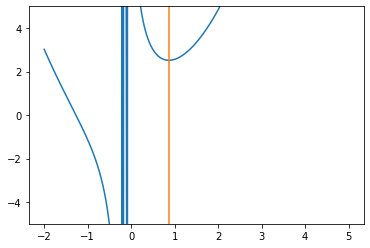

In [239]:
def test():
    c = torch.randn(4)
    x = torch.randn(4, requires_grad=True)
    f = -sum(torch.log(torch.sigmoid(x @ torch.randn(4))) for _ in range(10))
    A = hessian(f, x)
    gamma = 1

    T, U = utu_decomposition(A)
    print('A =', A, '\n')
    print('T =', T, '\n')
    print('U =', U, '\n')
    print('U @ T @ U.T =', U @ T @ U.T, '\n')

    tau = solve_auxilary_subproblem(T, c, gamma, 0.1)
    print('tau =', tau, '\n')

    xx = np.linspace(-2, 5, 1000)
    y = [auxilary_subproblem_objective(x, T, c, gamma) for x in xx]
    plt.plot(xx, y)
    plt.ylim(-5, 5)
    plt.plot([tau, tau], [-5, 5])

test()

A = tensor([[0.8517, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4831, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9770, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.6764]]) 

c = tensor([ 0.0000, 18.0366,  0.0000,  0.0000]) 

gamma = tensor([3.9940]) 

h = tensor([ 0.0000, -1.6285,  0.0000,  0.0000], grad_fn=<MvBackward>)


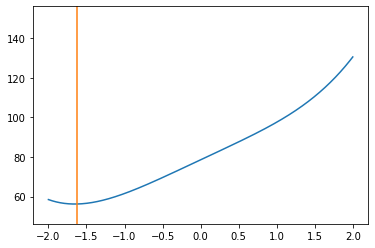

In [240]:
def test():
    A = torch.diag(torch.abs(torch.randn(4)))
    k = 1
    e_k = torch.zeros(4)
    e_k[k] = 1
    c = (10 + 10 * torch.abs(torch.randn(1))) * e_k
    gamma = 100 * torch.abs(torch.randn(1))

    print('A =', A, '\n')
    print('c =', c, '\n')
    print('gamma =', gamma, '\n')

    h = solve_auxilary_problem(A, c, gamma)
    print('h =', h)

    def f(h):
        return c @ h + .5 * c.T @ A @ c + gamma * torch.norm(h)**4 / 4

    xx = np.linspace(-2, 2, 1000)
    yy = [f(x * e_k) for x in xx]
    plt.plot(xx, yy)
    y1, y2 = min(yy) - 10, min(yy) + 100
    plt.ylim(y1, y2)
    plt.plot([h[k], h[k]], [y1, y2])

test()

A = tensor([[1.4197, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1215, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0601, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0137]]) 

c = tensor([ 0.0000, 14.6713,  0.0000,  0.0000]) 

gamma = tensor([73.0526]) 

h = tensor([ 2.0976e-12, -5.8467e-01,  8.4703e-12,  3.1826e-12],
       requires_grad=True)


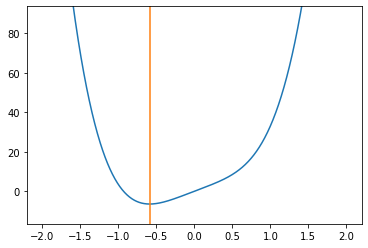

In [242]:
def test():
    A = torch.diag(torch.abs(torch.randn(4)))
    k = 1
    e_k = torch.zeros(4)
    e_k[k] = 1
    c = (10 + 10 * torch.abs(torch.randn(1))) * e_k
    gamma = 100 * torch.abs(torch.randn(1))
    h_0 = torch.ones_like(c)

    print('A =', A, '\n')
    print('c =', c, '\n')
    print('gamma =', gamma, '\n')

    h = solve_auxilary_problem_dummy_gd(A, c, gamma, h_0)
    print('h =', h)

    def f(h):
        return c @ h + .5 * h.T @ A @ h + gamma * torch.norm(h)**4 / 4

    xx = np.linspace(-2, 2, 1000)
    yy = [f(x * e_k) for x in xx]
    plt.plot(xx, yy)
    y1, y2 = min(yy) - 10, min(yy) + 100
    plt.ylim(y1, y2)
    plt.plot([h[k], h[k]], [y1, y2])

test()

# Bregman-distance gradient method

In [153]:
def BDGM(f, x_tilda_k, eps, L3):
    
    f_x_tilda_k = f(x_tilda_k)
    g_x_tilda_k = gradient(f_x_tilda_k, x_tilda_k, retain_graph=True)
    H_x_tilda_k = hessian(f_x_tilda_k, x_tilda_k)
    
    delta = 0.001 * eps**1.5 / (torch.norm(g_x_tilda_k)**0.5 + torch.norm(H_x_tilda_k)**1.5 / L3**0.5)
    
    d3 = D3(f_x_tilda_k, x_tilda_k)
    def phi_k():  # z = z_i, h_i = z - x_tilda_k
        return g_x_tilda_k @ h_i + H_x_tilda_k @ h_i @ h_i + d3 @ h_i @ h_i @ h_i + L3 * torch.norm(h_i)**4 / 4
    
    z_0 = x_tilda_k
    tau = 3 * delta / (8 * (2 + math.sqrt(2)) * torch.norm(g_x_tilda_k))
    print('tau', tau)
    
    
    def rho_k(z):
        '''
        Scaling function
        '''
        v = z - x_tilda_k
        return .5 * H_x_tilda_k @ v @ v + L3 * d_p(v, 4)
    
    def beta_rho_k(z_i, z):
        '''
        Bregman distance
        '''
        grad_rho_k = gradient(rho_k(z_i), z_i)
        return rho_k(z) - rho_k(z_i) - grad_rho_k @ (z - z_i)
    
    def g_x_tilda_k_tau():  # z = z_i, h_i = z - x_tilda_k
        x_p = x_tilda_k + tau * h_i
        grad_g_p = gradient(f(x_p), x_p)
        x_n = x_tilda_k - tau * h_i
        grad_g_n = gradient(f(x_n), x_n)
        r = 1 / tau**2 * (grad_g_p + grad_g_n - 2 * g_x_tilda_k)
        return r
    
    def g_phi_k_tau():  # z = z_i, h_i = z - x_tilda_k
        return g_x_tilda_k + H_x_tilda_k @ h_i + g_x_tilda_k_tau() + L3 * (h_i**2).sum() * h_i
    
    def auxilary_subproblem_dummy_objective(z, g_phi_k_tau_z_i, z_i): 
        value = g_phi_k_tau_z_i @ (z - z_i) + 2 * (1 + 2**(-.5)) * beta_rho_k(z_i, z)
        return value
    
    i = 0
    z_i = z_0
    while True:
#         print(i)
        h_i = z_i - x_tilda_k
        g_phi_k_tau_z_i = g_phi_k_tau()
        grad_f_z_i = gradient(f(z_i), z_i)
        if torch.norm(g_phi_k_tau_z_i) <= 1 / 6 * torch.norm(grad_f_z_i) - delta:
            break
        else:
            A = (2 + math.sqrt(2)) * H_x_tilda_k
            c = g_phi_k_tau_z_i - (2 + math.sqrt(2)) * (H_x_tilda_k @ h_i + L3 * (h_i**2).sum() * h_i)
            gamma = L3 * (2 + math.sqrt(2))    
#             h = solve_auxilary_problem_dummy_gd(A, c, gamma, h_i, 0.01, n_iter=10)
            h = solve_auxilary_problem_exact_newton(A, c, gamma, h_i)
#             h = solve_auxilary_problem(A, c, gamma, 0.1, n_iter=100)
            z_i = h + x_tilda_k
        i += 1
    print(i)
    return z_i

In [154]:
x_tilda_k = torch.randn(31, requires_grad=True)

In [157]:
def test(N):
    def f(x):
        return torch.nn.functional.binary_cross_entropy_with_logits(X @ x, y)

    f_x_tilda_k = f(x_tilda_k)
    g = gradient(f_x_tilda_k, x_tilda_k, retain_graph=True)
    h = hessian(f_x_tilda_k, x_tilda_k)
    d3 = D3(f_x_tilda_k, x_tilda_k)
    
    L3 = 5
    eps = 1e-5
    
    def phi_k(z):
        y = z - x_tilda_k
        return g @ y + h @ y @ y + d3 @ y @ y @ y + L3 * torch.norm(y)**4 / 4

    def is_feasible(z):
        return torch.norm(z - x_tilda_k) <= 2 * ((2 + math.sqrt(2)) * torch.norm(g) / L3) ** (1/3)

    times = []
    for _ in range(N):
        start = clock_gettime(CLOCK_MONOTONIC)
        z_opt = BDGM(f, x_tilda_k, eps, L3)
        end = clock_gettime(CLOCK_MONOTONIC)
        times.append(end - start)
    
    print('Time:', np.mean(times))
    
    print('z_opt =', z_opt)
    print('z_opt is feasible:', is_feasible(z_opt))
    
    print('phi_k(z_opt) =', phi_k(z_opt))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-1))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-2))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-3))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-4))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-5))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-6))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-7))

test(10)

tau tensor(7.3583e-13)
6
tau tensor(7.3583e-13)
6
tau tensor(7.3583e-13)
6
tau tensor(7.3583e-13)
6
tau tensor(7.3583e-13)
6
tau tensor(7.3583e-13)
6
tau tensor(7.3583e-13)
6
tau tensor(7.3583e-13)
6
tau tensor(7.3583e-13)
6
tau tensor(7.3583e-13)
6
Time: 0.1416508082067594
z_opt = tensor([ 0.2582, -0.2652,  0.6036,  1.4782,  1.0481, -0.0665, -0.5907, -0.2897,
        -0.1219, -0.4652,  0.8993, -0.6972, -0.0143,  0.3260, -0.1527,  1.1433,
        -0.9706, -0.9015, -0.3404,  0.5458,  0.5312, -1.1154,  0.8629,  0.7883,
        -0.3960,  1.5450,  1.7639, -0.8842,  0.3189,  0.8665,  1.1953],
       grad_fn=<AddBackward0>)
z_opt is feasible: tensor(True)
phi_k(z_opt) = tensor(-1.5024, grad_fn=<AddBackward0>)
z_opt is optimal: True
z_opt is optimal: True
z_opt is optimal: True
z_opt is optimal: True
z_opt is optimal: True
z_opt is optimal: False
z_opt is optimal: False


# Hyperfast Second-Order Method

In [130]:
def square_norm(x):
    return torch.sum(torch.tensor(x)**2)

def hyperfast_second_order_method(f, y_0, K, L3, eps):
    '''
    Algorithm 2: Hyperfast Second-Order Method
    '''
    A_0 = 0
    x_0 = y_0 
    x_tilda_k = x_0
    A_k = A_0
    x_k = x_0
    y_k = y_0
    for k in range(K):
        y_k_plus_1 = BDGM(f, x_tilda_k, eps, L3)
        y_k_plus_1.requires_grad_()
        lambda_min = 2 / (3 * L3 * square_norm(y_k_plus_1 - x_tilda_k))
        lambda_max = 1 / (L3 * square_norm(y_k_plus_1 - x_tilda_k))
        lambda_k_plus_1 = (lambda_min + lambda_max) / 2
        a_k_plus_1 = 1 / 2 * (lambda_k_plus_1 +
                              (lambda_k_plus_1 ** 2 +
                               4 * lambda_k_plus_1 * A_k) ** 0.5)
        A_k_plus_1 = a_k_plus_1 + A_k
        x_tilda_k = A_k * y_k / A_k_plus_1 + a_k_plus_1 * x_k / A_k_plus_1
        x_k = x_k - a_k_plus_1 * torch.autograd.grad([f(y_k_plus_1)],
                                                     [y_k_plus_1],
                                                     create_graph=True)[0]
        A_k = A_k_plus_1
        y_k = y_k_plus_1
        print(f(y_k))
    return y_k

In [134]:
y_0 = torch.randn(31, requires_grad=True)

In [135]:
y_0

tensor([ 1.0220,  0.7849, -1.0733,  0.0301, -1.0313,  0.2381, -2.0226, -0.0070,
         0.7885, -0.2347, -0.0379,  1.4524, -1.8557, -0.9215,  1.7471, -0.4450,
        -1.8847, -1.1115, -0.7888, -0.5549,  0.8807, -1.3708, -0.4310,  0.3241,
         0.0370, -0.1122,  0.4678,  1.5024,  1.6491, -0.6438, -1.2041],
       requires_grad=True)

In [148]:
def test(N):
    L3 = 5
    eps = 1e-5
    delta = 1e-9
    K = 50
    
    def f(x):
        return torch.nn.functional.binary_cross_entropy_with_logits(X @ x, y)
    
    times = []
    for _ in range(N):
        start = clock_gettime(CLOCK_MONOTONIC)
        y_opt = hyperfast_second_order_method(f, y_0, K, L3, eps)
        end = clock_gettime(CLOCK_MONOTONIC)
        times.append(end - start)
    
    print('Time:', np.mean(times))
    
    print('y_opt', y_opt)
    print('f(y_opt) =', f(y_opt))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-1))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-2))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-3))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-4))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-5))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-6))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-7))

test(1)

tau tensor(2.6158e-12)
0
1
2
3
4
5
6
tensor(1.7098, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(2.6158e-12)
0
1
2
3
4
5


/home/ivb/miniconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


6
tensor(1.7098, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(3.6625e-12)
0
1
2
3
4
5
6
tensor(1.3753, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(5.0386e-12)
0
1
2
3
4
5
6
tensor(1.1686, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(8.2930e-12)
0
1
2
3
4
5
6
tensor(0.9069, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(1.1719e-11)
0
1
2
3
4
5
6
tensor(0.7201, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(1.8771e-11)
0
1
2
3
4
5
6
tensor(0.5458, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(2.9473e-11)
0
1
2
3
4
5
6
tensor(0.4237, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(4.7534e-11)
0
1
2
3
4
5
6
tensor(0.3297, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(8.0475e-11)
0
1
2
3
4
5
6
tensor(0.2716, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(1.0074e-10)
0
1
2
3
4
5
6
tensor(0.2358, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(1.1236e-10)
0
1
2
3
4
5


KeyboardInterrupt: 